In [1]:
import sys
sys.path.insert(0,'..')
%pylab inline

%load_ext autoreload
%autoreload 2
import jax.numpy as np
import jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tomo_challenge import metrics
from tomo_challenge.data import load_magnitudes_and_colors, load_redshift

In [3]:
z = load_redshift('../riz/validation.hdf5')

In [4]:
batch_z = z[:10000]

In [5]:
# Let's try just one bin
bins = np.ones_like(batch_z).astype('int32') - 1

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
mu, C, b = metrics.compute_mean_covariance(bins, batch_z, '3x2')

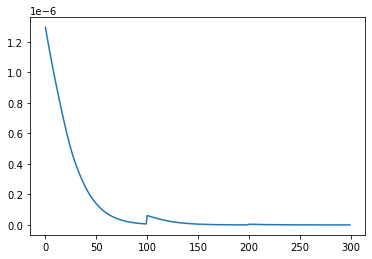

In [7]:
plot(mu)

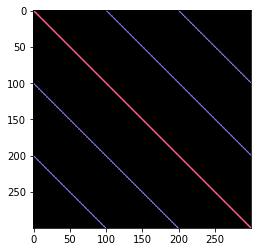

In [8]:
imshow(C>0,cmap='gist_stern')

In [9]:
# Cool cool, now let's do the same with JAX
from tomo_challenge import jax_metrics
weights = np.expand_dims(np.ones_like(batch_z), -1)

In [10]:
mu2, C2 = jax_metrics.compute_mean_covariance(weights,batch_z)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

Text(0.5, 1.0, 'Mean data vector')

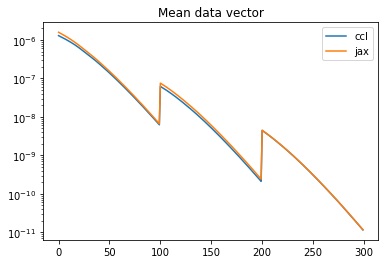

In [11]:
semilogy(mu, label='ccl')
semilogy(mu2, label='jax')
legend()
title('Mean data vector')

Text(0.5, 1.0, 'Diagonal of covariance')

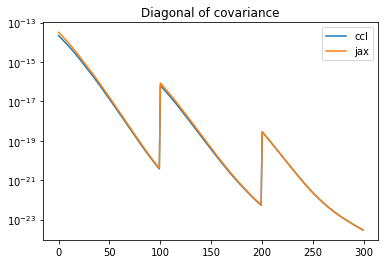

In [12]:
semilogy(diag(C), label='ccl')
semilogy(diag(C2), label='jax')
legend()
title('Diagonal of covariance')

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(cov, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  #cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

In [97]:
# And now.... for the moment of truth ^^' Let's try to compute
# th Fisher
sacc_data = metrics.make_sacc(bins, batch_z, '3x2', mu, C)

In [121]:
fom, F1 = metrics.figure_of_merit(sacc_data, '3x2', b, return_fisher=True)

Running in serial mode (one process).

Parameter Priors
----------------
params--omega_k  ~ delta(0.0)
params--omega_c  ~ U(0.25, 0.32)
params--omega_b  ~ U(0.04, 0.05)
params--h        ~ U(0.5, 0.9)
params--n_s      ~ U(0.9, 1.02)
params--sigma8   ~ U(0.74, 0.94)
params--w0       ~ delta(-1.0)
params--wa       ~ delta(0.0)
params--bias_0   ~ delta(1.5555454189409623)


****************************
* Running sampler 1/1: fisher
* Saving output -> tmp/chain.txt
****************************
Calculating derivatives using 20 total models


In [122]:
print(fom)

611.9884696836078


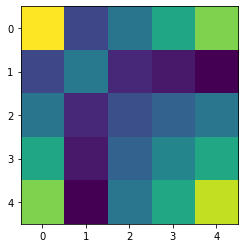

In [123]:
imshow(F1)

In [124]:
fid_params = np.array([0.27, 0.045, 0.67, 0.96, 0.840484495])

In [125]:
import yaml
config = yaml.safe_load(open("./tomo_challenge/config.yml"))

# Pull out the correct indices.  We would like to use
# w0 - wa but can't yet because
param_names = list(config['cosmosis']['parameters'].keys())
i = param_names.index('Omega_c')
j = param_names.index('sigma8')

In [126]:
covmat_chunk1d = inv(F1)[:, [i, j]][[i, j], :]

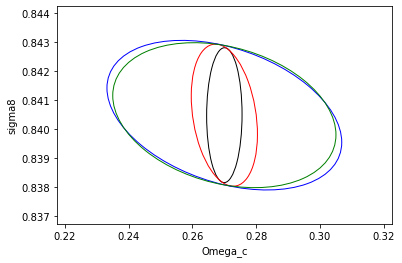

In [127]:
# That's for step size of 0.02
ax = subplot(111)
plot_contours(covmat_chunk1, fid_params[[i,j]] , ax=ax, fill=False); # 0.02
plot_contours(covmat_chunk1b, fid_params[[i,j]] , ax=ax, fill=False,color='red'); # 0.01
plot_contours(covmat_chunk1c, fid_params[[i,j]] , ax=ax, fill=False,color='blue'); # 0.002
plot_contours(covmat_chunk1d, fid_params[[i,j]] , ax=ax, fill=False,color='green'); # 0.005



#plot_contours(covmat_chunk1b, fid_params[[i,j]] , ax=ax, fill=False);
#plot_contours(covmat_chunk1c, fid_params[[i,j]] , ax=ax, fill=False);

xlabel('Omega_c');
ylabel('sigma8');

In [48]:
# Defining the derivatives of the data vector
@jax.jit
def mean(params):
    mu, C = jax_metrics.compute_mean_covariance(weights, batch_z,
                                                params)
    return mu

In [49]:
jac1 = jax.jacfwd(mean)(fid_params)

In [50]:
jac1.shape

(300, 5)

In [141]:
# so a basic fisher matrix with constant covariance would look like
# this 
F2 = np.einsum('pa,pq,qb->ab', jac1, np.linalg.inv(C2), jac1)

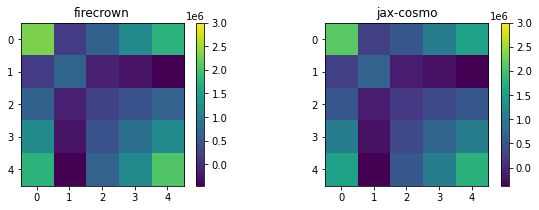

In [142]:
figure(figsize=(10,3))
subplot(121)
imshow(F1,vmax=3e6)
title('firecrown')
colorbar()
subplot(122)
imshow(F2,vmax=3e6)
title('jax-cosmo')
colorbar()

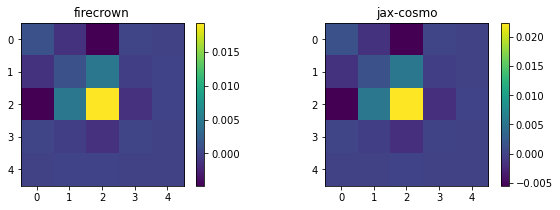

In [143]:
figure(figsize=(10,3))
subplot(121)
imshow(inv(F1))
title('firecrown')
colorbar()
subplot(122)
imshow(inv(F2))
title('jax-cosmo')
colorbar()

In [144]:
covmat_chunk1 = inv(F1)[:, [i, j]][[i, j], :]
covmat_chunk2 = inv(F2)[:, [i, j]][[i, j], :]

In [145]:
6.17 * np.pi * np.sqrt(np.linalg.det(covmat_chunk1))

DeviceArray(0.00163402, dtype=float32)

In [146]:
6.17 * np.pi * np.sqrt(np.linalg.det(covmat_chunk2))

DeviceArray(0.00186314, dtype=float32)

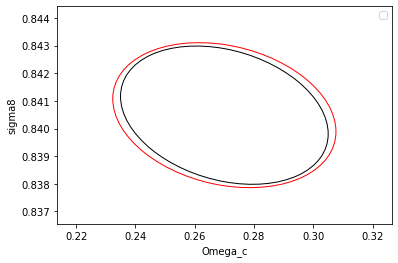

In [148]:
# That's for step size of 0.1
ax = subplot(111)
plot_contours(covmat_chunk1, fid_params[[i,j]] , ax=ax, fill=False);
plot_contours(covmat_chunk2, fid_params[[i,j]] , fill=False, color='r');

legend()


xlabel('Omega_c');
ylabel('sigma8');

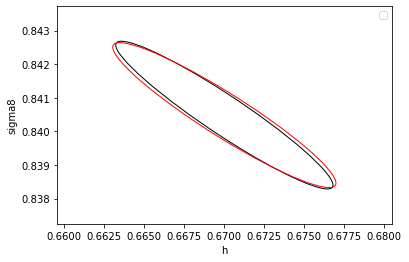

In [81]:
# That's for step size of 0.02
ax = subplot(111)
plot_contours(covmat_chunk1, fid_params[[i,j]] , ax=ax, fill=False);
plot_contours(covmat_chunk2, fid_params[[i,j]] , fill=False, color='r');
xlabel('h');
ylabel('sigma8');
legend()

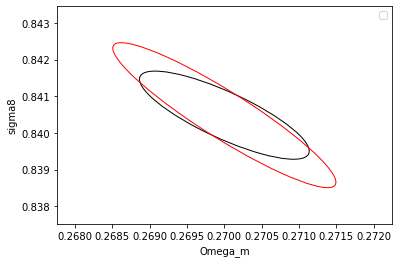

In [190]:
# That's for step size of 0.1
ax = subplot(111)
plot_contours(covmat_chunk1, fid_params[[i,j]] , ax=ax, fill=False);
plot_contours(covmat_chunk2, fid_params[[i,j]] , fill=False, color='r');
xlabel('Omega_m');
ylabel('sigma8');
legend()

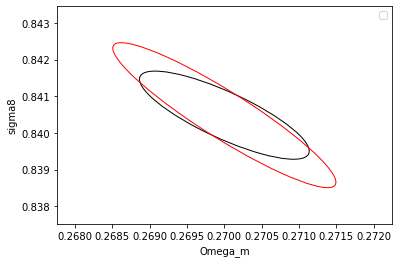

In [192]:
# That's for step size of 0.05
ax = subplot(111)
plot_contours(covmat_chunk1, fid_params[[i,j]] , ax=ax, fill=False);
plot_contours(covmat_chunk2, fid_params[[i,j]] , fill=False, color='r');
xlabel('Omega_m');
ylabel('sigma8');
legend()

(0.825, 0.855)

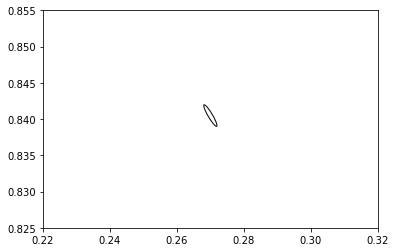

In [156]:
plot_contours(covmat_chunk2, fid_params[[i,j]] , fill=False);
ylim(0.825, 0.855)
xlim(0.22, 0.32)
ylim(0.825, 0.855)

In [56]:
params[[i,j)]

DeviceArray([0.22, 0.22], dtype=float32)

In [60]:
params

DeviceArray([0.22], dtype=float32)

In [58]:
j

3

In [69]:
# All.... right, let's try to compute it with JAX
def likelihood(params):
    mu, C = jax_metrics.compute_mean_covariance(weights, batch_z,
                                                params) 
    fake_data = jax.lax.stop_gradient(mu)
    const_cov = jax.lax.stop_gradient(C)

    r = (fake_data - mu)
    return -0.5 * r.T @ np.linalg.inv(const_cov) @ r

In [70]:
# Defining the derivatives of the data vector
@jax.jit
def mean(params):
    mu, C = jax_metrics.compute_mean_covariance(weights, batch_z,
                                                params)
    return mu

In [71]:
jac1 = jax.jit(jax.jacobian(mean))(fid_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

In [79]:
jac1 = np.stack(jac1, axis=-1)

In [80]:
# so a basic fisher matrix with constant covariance would look like
# this 
F2 = np.einsum('pa,pq,qb->ab', jac1, np.linalg.inv(C2), jac1)

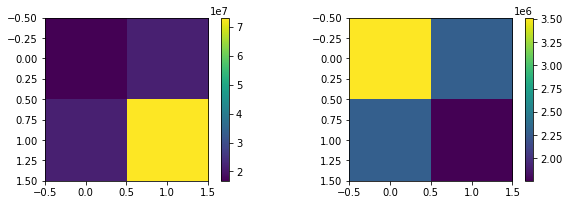

In [88]:
figure(figsize=(10,3))
subplot(121)
imshow(F1)
colorbar()
subplot(122)
imshow(F2)
colorbar()

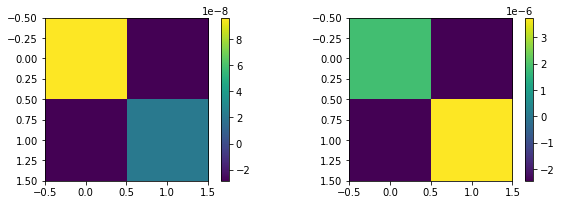

In [90]:
figure(figsize=(10,3))
subplot(121)
imshow(pinv(F1))
colorbar()
subplot(122)
imshow(pinv(F2[:,:]))
colorbar()

In [91]:
6.17 * np.pi * np.sqrt(np.linalg.det(pinv(F1)))

DeviceArray(7.032991e-07, dtype=float32)

In [92]:
6.17 * np.pi * np.sqrt(np.linalg.det(pinv(F2)))

DeviceArray(1.9983998e-05, dtype=float32)

In [ ]:
pinv(F1)

In [32]:
jac1.shape

(300, 5)

In [33]:
jac1_again = jax.jit(jax.jacobian(mean))(fid_params)

In [34]:
jac1.shape

(300, 5)

In [56]:
import yaml
config = yaml.safe_load(open("./tomo_challenge/config.yml"))

In [57]:
config

{'parameters': {'Omega_k': 0.0,
  'Omega_c': 0.27,
  'Omega_b': 0.045,
  'h': 0.67,
  'n_s': 0.96,
  'sigma8': 0.8404844953840714,
  'w0': -1.0,
  'wa': 0.0},
 'cosmosis': {'sampler': 'fisher',
  'debug': False,
  'quiet': True,
  'mpi': False,
  'fisher': {'step_size': 0.02},
  'parameters': {'Omega_c': [0.25, 0.27, 0.32],
   'Omega_b': [0.04, 0.045, 0.05],
   'h': [0.5, 0.67, 0.9],
   'sigma8': [0.74, 0.8404844953840714, 0.94],
   'n_s': [0.9, 0.96, 1.02]}},
 'two_point': {'module': 'firecrown.ccl.two_point',
  'sacc_data': 0,
  'sources': {},
  'systematics': {},
  'statistics': {},
  'likelihood': {'kind': 'ConstGaussianLogLike', 'data_vector': {}}}}

In [58]:
param_names = list(config['cosmosis']['parameters'].keys())
i = param_names.index('Omega_c')
j = param_names.index('sigma8')

In [59]:
param_names

['Omega_c', 'Omega_b', 'h', 'sigma8', 'n_s']

In [38]:
# so a basic fisher matrix with constant covariance would look like
# this 
F2 = np.einsum('pa,pq,qb->ab', jac1, np.linalg.inv(C2), jac1)

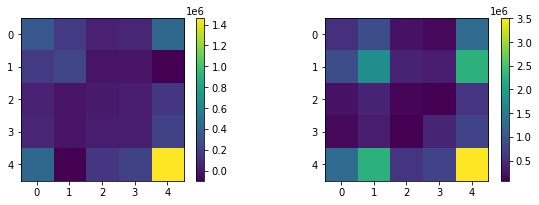

In [61]:
figure(figsize=(10,3))
subplot(121)
imshow(F1*0.02)
colorbar()
subplot(122)
imshow(F2[::-1,::-1])
colorbar()

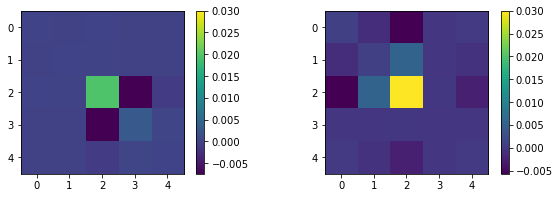

In [52]:
figure(figsize=(10,3))
subplot(121)
imshow(pinv(F1)/0.02,vmax=0.03)
colorbar()
subplot(122)
imshow(pinv(F2[:,:]),vmax=0.03)
colorbar()

In [19]:
fid_params = np.array([0.22, 0.04447927, 0.71, 0.8, 0.963])

In [20]:
likelihood(fid_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

DeviceArray(0., dtype=float32)

In [24]:
jax.jacrev(likelihood)(fid_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

DeviceArray([0., 0., 0., 0., 0.], dtype=float32)

In [25]:
jax.jacfwd(likelihood)(fid_params)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

DeviceArray([0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
jax.

In [19]:
hess_likelihood = jax.jit(jax.hessian(likelihood))

In [ ]:
hess_likelihood(fid_params)

<module 'numpy' from '/usr/lib/python3.8/site-packages/numpy/__init__.py'>